In [1]:
from fastai2.text.all import *

In [2]:
TextDataBunch.from_folder('data/en-100/')

AttributeError: 'str' object has no attribute 'parent'

## Create databunch form LM

In [19]:
BPTT=10
BS=64

EN_FILE = Path('data/en-clean.txt')
EN_TEXT = EN_FILE.read()[1:].replace('\n', '').replace('  ', ' ')

In [20]:
toks = tokenize1(EN_TEXT)

In [21]:
toks[:10]

(#10) ['xxbos','the','project','gutenberg','ebook','of','peter','pan',',','by']

In [22]:
vocab = make_vocab(Counter(toks), min_freq=3, max_vocab=2000)

len(vocab)

2008

In [23]:
vocab[:15]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 ',',
 '.',
 'the',
 'and',
 'to',
 'a']

In [24]:
# arbitrary way of splitting text into 'examples', would probably be better to split by chapters
# or something along these lines but shouldn't make much of a difference
txts = np.array_split(EN_TEXT.split(), 100)

In [25]:
dblock = DataBlock(blocks=(TextBlock(vocab, is_lm=True)), splitter=RandomSplitter(seed=42))

In [26]:
dbunch_lm = dblock.databunch(txts, seq_len=BPTT, bs=BS) 

In [27]:
dbunch_lm.one_batch()[0].shape

torch.Size([64, 10])

In [28]:
# % of unknown tokens
torch.mean((torch.cat([tup[0] for tup in dbunch_lm.valid_ds]) == 0).float())

tensor(0.1104)

## Train LM

In [29]:
# def loss():
#     preds = []
#     targs = []

#     learn.model.eval()
#     with torch.no_grad():
#         for b in learn.dbunch.valid_dl:
#             preds.append(learn.model(b[0])[0])
#             targs.append(b[1])

#     preds = torch.cat(preds, 1)
#     targs = torch.cat(targs, 1)
    
#     return CrossEntropyLossFlat()(preds, targs).item(), accuracy(preds,targs).item()

In [30]:
class PermuteEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, padding_idx):
        super().__init__()
        
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.padding_idx = padding_idx
        
        # to conform to nn.Embedding api
        self.max_norm=None
        self.norm_type=2.0
        self.scale_grad_by_freq=False
        self.sparse = False

        self.weight = nn.Parameter( torch.Tensor(num_embeddings, embedding_dim) ) # these are embeddings!
        
        self.p_matrix_as_embeddings = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.p_matrix_as_embeddings.weight = nn.Parameter(torch.eye(self.num_embeddings))
        self.p_matrix_as_embeddings.weight.requires_grad = False
        
    def forward(self, words):
#         set_trace()
        return self.p_matrix_as_embeddings(words) @ self.weight
    
    def reset_parameters(self): pass

In [31]:
class pAWD_LSTM(AWD_LSTM):
    def __init__(self, vocab_sz, emb_sz, n_hid, n_layers, pad_token=1, hidden_p=0.2, input_p=0.6, embed_p=0.1,
                 weight_p=0.5, bidir=False, packed=False):
        store_attr(self, 'emb_sz,n_hid,n_layers,pad_token,packed')
        self.bs = 1
        self.n_dir = 2 if bidir else 1
#         self.encoder = nn.Embedding(vocab_sz, emb_sz, padding_idx=pad_token)
        self.encoder = PermuteEmbedding(vocab_sz, emb_sz, padding_idx=pad_token)
#         self.encoder_dp = EmbeddingDropout(self.encoder, embed_p)
        self.encoder_dp = self.encoder # chosing to train without embedding dropout (to reduce code complexity + not sure it makes a lot of sense for what we want to do anyhow) 
        self.rnns = nn.ModuleList([self._one_rnn(emb_sz if l == 0 else n_hid, (n_hid if l != n_layers - 1 else emb_sz)//self.n_dir,
                                                 bidir, weight_p, l) for l in range(n_layers)])
        self.encoder.weight.data.uniform_(-self.initrange, self.initrange)
        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])

In [32]:
import fastai2
fastai2.text.models.core._model_meta[pAWD_LSTM] = fastai2.text.models.core._model_meta[AWD_LSTM]

In [33]:
WD=1e-7

def opt(params, lr):
    return Adam(params, lr, mom=0.8, sqr_mom=0.99)

drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])

config = dict(
    emb_sz=100,
    n_hid=1024,
    n_layers=3,
    input_p=drops[0],
    hidden_p=drops[1],
    weight_p=drops[2],
    embed_p=drops[3])

awd_lstm_lm_config.update(config)

learn = language_model_learner(
    dbunch_lm,
    pAWD_LSTM,
    opt_func=opt,
    pretrained=False,
    config=awd_lstm_lm_config,
    drop_mult=0.2,
    metrics=[accuracy, Perplexity()]
)

In [17]:
learn.fit(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.487010,5.218735,0.124805,184.700348,00:10
1,5.062149,4.800918,0.173785,121.621971,00:10
2,4.788030,4.555896,0.204188,95.192039,00:10
3,4.619162,4.407209,0.222027,82.040199,00:11
4,4.470920,4.311631,0.232075,74.561981,00:11
5,4.370491,4.220758,0.240082,68.085068,00:11
6,4.255107,4.160259,0.244488,64.088104,00:11
7,4.192817,4.109135,0.248003,60.894001,00:11
8,4.094905,4.066043,0.255534,58.325733,00:11
9,4.000208,4.054609,0.253494,57.662628,00:10


In [125]:
# learn.save('pLSTM_mixer_10epochs')

In [34]:
learn.load('pLSTM_mixer_10epochs')

In [36]:
learn.predict('peter was', n_words=3, temperature=0.5)

'peter was a very great'

In [37]:
import warnings

@patch_to(LMLearner)
def optimize_permutation(self):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        self.freeze_to(4)
    learn.model[0].encoder.p_matrix_as_embeddings.weight.requires_grad = True
    
@patch_to(LMLearner)
def optimize_model(self):
    self.unfreeze()
    learn.model[0].encoder.p_matrix_as_embeddings.weight.requires_grad = False

In [38]:
learn.optimize_permutation()

In [299]:
def aza_loss(input=None, target=None, scaling_factor=5/2000, debug=False):
    p = learn.model[0].encoder.p_matrix_as_embeddings.weight
    sums_to_one = (1-p.abs().sum(dim=0)).abs().sum() + (1-p.abs().sum(dim=1)).abs().sum()
#     extremize = (1-p.max(dim=0)[0]).abs().sum() + (1-p.max(dim=1)[0]).abs().sum() # + (p.min(dim=0)[0]).abs().max()#(10*(1-p.max()).abs()) + (10*p.min()).abs()
    the_model = CrossEntropyLossFlat()(input, target)
    if debug: return sums_to_one, the_model
    else:     return scaling_factor * sums_to_one + (1 - scaling_factor) * the_model

In [40]:
def aza_loss(input=None, target=None, scaling_factor=5/2000, debug=False):
    p = learn.model[0].encoder.p_matrix_as_embeddings.weight
    sums_to_one = (1-p.abs().sum(dim=1)).abs().sum()
#     extremize = (1-p.max(dim=0)[0]).abs().sum() + (1-p.max(dim=1)[0]).abs().sum() # + (p.min(dim=0)[0]).abs().max()#(10*(1-p.max()).abs()) + (10*p.min()).abs()
    the_model = CrossEntropyLossFlat()(input, target)
    if debug: return sums_to_one, the_model
    else:     return scaling_factor * sums_to_one + (1 - scaling_factor) * the_model

In [41]:
learn.loss_func = aza_loss

In [42]:
learn.model[0].encoder.p_matrix_as_embeddings.weight

Parameter containing:
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0', requires_grad=True)

In [44]:
preds, targs = learn.get_preds()

In [45]:
aza_loss(preds, targs, debug=True)

(tensor(0., device='cuda:0', grad_fn=<SumBackward0>), tensor(4.0356))

In [46]:
nn.init.kaiming_normal_(learn.model[0].encoder.p_matrix_as_embeddings.weight)

Parameter containing:
tensor([[ 0.0061,  0.0682, -0.0054,  ...,  0.0199,  0.0017,  0.0047],
        [ 0.0153, -0.0331,  0.0190,  ..., -0.0155, -0.0411, -0.0339],
        [-0.0742,  0.0011, -0.0191,  ..., -0.0256,  0.0423,  0.0304],
        ...,
        [ 0.0003,  0.0006, -0.0014,  ...,  0.0211, -0.0158, -0.0175],
        [ 0.0204,  0.0196, -0.0005,  ..., -0.0124, -0.0122, -0.0268],
        [ 0.0220, -0.0593, -0.0140,  ..., -0.0544,  0.0332,  0.0392]],
       device='cuda:0', requires_grad=True)

In [47]:
aza_loss(preds, targs, debug=True)

(tensor(99512.8359, device='cuda:0', grad_fn=<SumBackward0>), tensor(4.0356))

In [48]:
learn.fit(15, 1e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,92.906197,70.563141,0.216645,4417562433821847989135681257472.000000,00:09
1,18.639759,12.710135,0.223980,331086.343750,00:09
2,5.461504,5.112665,0.225412,166.112488,00:09
3,4.576769,4.590343,0.229384,98.528175,00:09
4,4.379544,4.421916,0.233398,83.255653,00:09
5,4.286121,4.361105,0.236675,78.343651,00:09
6,4.223916,4.319010,0.239692,75.114250,00:09
7,4.163378,4.297636,0.241167,73.525772,00:09
8,4.176008,4.285646,0.241775,72.649460,00:09
9,4.177070,4.275221,0.242947,71.896019,00:09


In [306]:
learn.fit(15, 1e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,172.963409,127.938080,0.196181,inf,00:10
1,26.927685,15.854390,0.206576,7681997.500000,00:10
2,5.131521,4.866365,0.212609,129.848114,00:10
3,4.567665,4.613162,0.218815,100.802391,00:10
4,4.448627,4.483438,0.224674,88.538589,00:10
5,4.416282,4.451097,0.229340,85.720970,00:10
6,4.351192,4.412767,0.234418,82.497452,00:10
7,4.309026,4.392875,0.234180,80.872574,00:09
8,4.315354,4.389675,0.234896,80.614189,00:10
9,4.311879,4.373653,0.237630,79.332939,00:10


In [307]:
learn.save('pLSTM_mixer_15epochs_permute_embeddings')

In [50]:
def hitInTopN(n=1, how_many=None, prints=True):
    data = learn.model[0].encoder.p_matrix_as_embeddings.weight.argsort(descending=True)[10:10+how_many, :n]
    hits = torch.any(data == torch.arange(10, how_many+10).reshape(-1,1).cuda(), -1)
    return hits.float().mean().item()

In [51]:
hitInTopN(1, 100), hitInTopN(5, 100)

(0.5799999833106995, 0.9300000071525574)

In [311]:
hitInTopN(1, 100), hitInTopN(5, 100)

(0.7400000095367432, 1.0)

In [52]:
acc1 = [(x, hitInTopN(1, x)) for x in range(50,1500,200)]
acc2 = [(x, hitInTopN(2, x)) for x in range(50,1500,200)]
acc3 = [(x, hitInTopN(3, x)) for x in range(50,1500,200)]
acc5 = [(x, hitInTopN(5, x)) for x in range(50,1500,200)]
acc10 = [(x, hitInTopN(10, x)) for x in range(50,1500,200)]

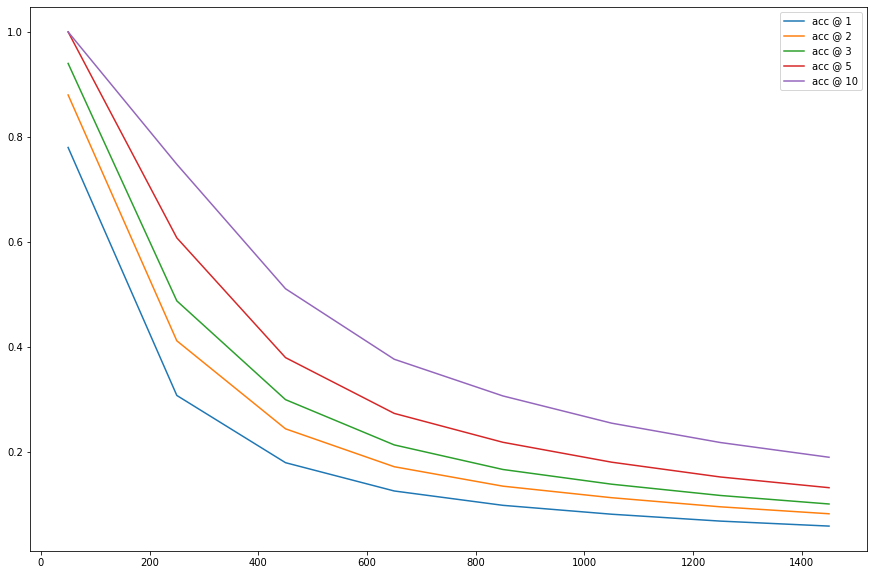

In [53]:
plt.figure(figsize=(15,10))
plt.plot(*zip(*acc1))
plt.plot(*zip(*acc2))
plt.plot(*zip(*acc3))
plt.plot(*zip(*acc5))
plt.plot(*zip(*acc10))
plt.legend([f'acc @ {x}' for x in [1,2,3,5,10]])

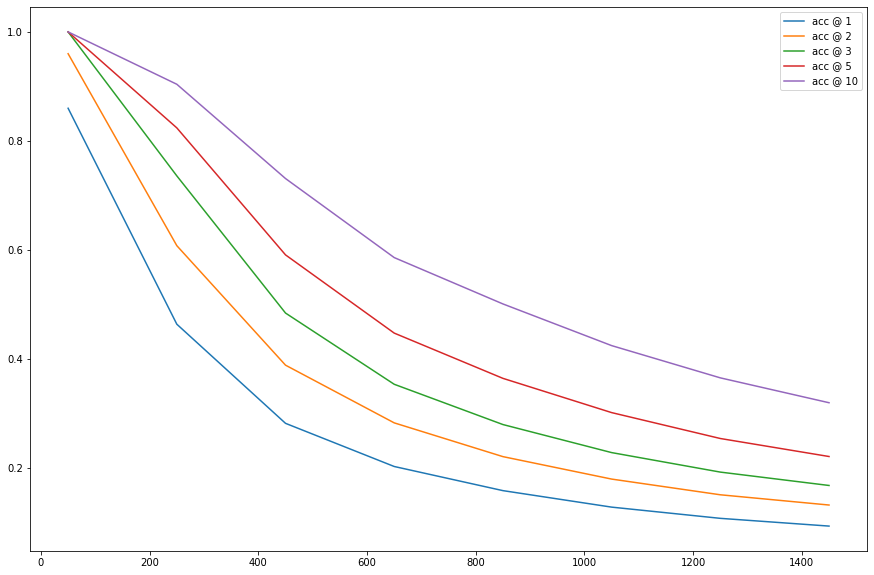

In [313]:
plt.figure(figsize=(15,10))
plt.plot(*zip(*acc1))
plt.plot(*zip(*acc2))
plt.plot(*zip(*acc3))
plt.plot(*zip(*acc5))
plt.plot(*zip(*acc10))
plt.legend([f'acc @ {x}' for x in [1,2,3,5,10]])

In [317]:
data = learn.model[0].encoder.p_matrix_as_embeddings.weight.argsort(descending=True)[:, :5]
print('actual word\t\tpredictions\n')
for i in range(60, 80):
    print(f'{learn.dbunch.vocab[i]}\t\t{[learn.dbunch.vocab[idx] for idx in data[i]]}')

actual word		predictions

would		['would', 'could', 'should', 'must', 'shall']
then		['then', 'presently', 'however', 'but', 'though']
we		['we', 'i', 'you', 'they', 'she']
my		['my', 'your', 'you', '-', 'tinker']
what		['what', 'who', 'that', 'why', '?']
up		['up', 'out', 'down', 'away', 'on']
from		['from', 'at', 'upon', 'into', 'in']
which		['which', 'who', 'there', 'if', 'that']
out		['out', 'up', 'down', 'away', 'forth']
me		['me', 'us', 'ai', 'anything', 'him']
one		['one', 'this', 'copies', 'two', 'an']
if		['when', 'if', 'although', 'unless', 'must']
now		['now', 'oh', 'but', 'however', 'then']
when		['when', 'whether', 'if', 'which', ':']
them		['him', 'them', 'himself', 'us', 'it']
or		['or', 'and', 'nor', 'which', 'chapter']
could		['would', 'could', 'wo', 'should', 'might']
been		['been', "'re", 'be', 'were', 'was']
are		['is', 'are', 'am', 'was', "'s"]
an		['an', 'the', 'your', 'a', 'project']
